In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

# import gymnasium as gym
import stable_baselines3 as  stabas

In [2]:
def dataRetriever(ticker_list):
    df = []
    for i in range(0,len(ticker_list),1):
        individual_stock_data = yf.download(ticker_list[i], start="2020-02-19", end="2025-02-18")
        df.append(individual_stock_data)
    return df

In [3]:
my_stocks = ["EQNR.OL", "YAR.OL",  "LSG.OL"]
my_data = dataRetriever(my_stocks)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


https://medium.com/@paulswenson2/an-introduction-to-building-custom-reinforcement-learning-environment-using-openai-gym-d8a5e7cf07ea

In [7]:
import gymnasium as gym
from gymnasium import spaces, Env

import random

# import clear_output
import os

from stable_baselines3 import PPO 
from stable_baselines3.common.env_util import make_vec_env

In [5]:
close_values = [[my_data[1]["Close"].iloc[x][0],my_data[1]["Close"].iloc[x][0],my_data[2]["Close"].iloc[x][0]] for x in range(0, my_data[0].shape[0])]
esg_scores = [27,25, 29]

C:\Users\Jakob\AppData\Local\Temp\ipykernel_46516\2741794884.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  close_values = [[my_data[1]["Close"].iloc[x][0],my_data[1]["Close"].iloc[x][0],my_data[2]["Close"].iloc[x][0]] for x in range(0, my_data[0].shape[0])]


In [ ]:
class PortfolioEnv(Env):

    def __init__(self, stock_data, esg_data):
        """
        Custom portfolio management environment
        """

        # Define necessary market data
        self.prices = np.array(stock_data)
        self.esg_scores = np.array(esg_data)
        self.num_stocks = self.prices.shape[1]
        self.lookback = 10
        self.initial_cash = 100

        # What does this do?
        super().__init__()

        # Observational space
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.lookback, self.num_stocks + 1), dtype=np.float32)
        # Action space
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_stocks + 1,), dtype=np.float32)

        self.reset()



    def reset(self, seed=None, options=None):
        """
        Resets the environment to the initial state
        """
        self.current_step = self.lookback 
        self.portfolio_value  = self.initial_cash
        self.weights = np.array([1 / (self.num_stocks+1)] * (self.num_stocks+1))
        self.done = False

        return self._get_observation(), {}



    def step(self, action):
        """
        Executes an action and returns the next state
        """
        action = np.clip(action, 0, 1)

        # Prevent division by zero when normalizing actions
        if action.sum() == 0:
            action = np.ones_like(action) / len(action)  # Assign equal weights

        action /= action.sum()

        previous_prices = self.prices[self.current_step -1]
        current_prices = self.prices[self.current_step]
        returns = (current_prices - previous_prices) / previous_prices

        portfolio_return = np.dot(self.weights[:-1], returns)
        self.portfolio_value *= (1+ portfolio_return)

        self.weights = action

        esg_score = np.dot(self.weights[:-1], self.esg_scores)
        esg_penalty = max(0, esg_score -27)

        reward = portfolio_return - 0.1 * esg_penalty


        self.current_step += 1 
        self.done = self.current_step  >= len(self.prices) - 1

        if np.isnan(action).any() or np.isinf(action).any():
            raise ValueError(f"Invalid action: {action}")

        return self._get_observation(),  reward, self.done, False, {}
    
    def _get_observation(self):
        """ Returns the current market state as observation """
        prices = self.prices[self.current_step - self.lookback:self.current_step]  # Shape: (10, num_stocks)
        portfolio_state = np.full((self.lookback, 1), self.portfolio_value, dtype=np.float32)  # Shape: (10, 1)

        obs = np.hstack((prices, portfolio_state))  # Expected shape: (10, num_stocks + 1)
        return obs.astype(np.float32)  # Ensure dtype is correct




    def render(self):
        """
        Optional visualization
        """
        print(f"Step: {self.current_step}, Portfolio Value: {self.portfolio_value:.2f}")


In [12]:
env = PortfolioEnv(close_values, esg_scores)
obs = env.reset()[0]
print("Observation shape:", obs.shape)  # Should print (10, num_stocks + 1)
print("Action space shape:", env.action_space.shape)  # Should match (num_stocks + 1,)

Observation shape: (10, 4)
Action space shape: (4,)


In [13]:
env = make_vec_env(lambda: PortfolioEnv(close_values,  esg_scores), n_envs=1)
model = PPO("MlpPolicy", env , verbose=1)
model.learn(total_timesteps=100_000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.25e+03 |
|    ep_rew_mean     | -24.5    |
| time/              |          |
|    fps             | 2823     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.25e+03    |
|    ep_rew_mean          | -23.4       |
| time/                   |             |
|    fps                  | 1229        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007458883 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.69       |
|    explained_variance   | 0.0559      |
|    learning

In [14]:
env = PortfolioEnv(close_values, esg_scores)
obs, _ = env.reset()

done = False
while not done:
    action, _states = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    env.render()


Step: 11, Portfolio Value: 101.28
Step: 12, Portfolio Value: 100.58
Step: 13, Portfolio Value: 98.84
Step: 14, Portfolio Value: 98.03
Step: 15, Portfolio Value: 97.94
Step: 16, Portfolio Value: 94.78
Step: 17, Portfolio Value: 91.50
Step: 18, Portfolio Value: 93.38
Step: 19, Portfolio Value: 89.21
Step: 20, Portfolio Value: 91.10
Step: 21, Portfolio Value: 86.74
Step: 22, Portfolio Value: 95.45
Step: 23, Portfolio Value: 97.74
Step: 24, Portfolio Value: 96.00
Step: 25, Portfolio Value: 98.53
Step: 26, Portfolio Value: 97.73
Step: 27, Portfolio Value: 98.91
Step: 28, Portfolio Value: 96.37
Step: 29, Portfolio Value: 98.80
Step: 30, Portfolio Value: 100.48
Step: 31, Portfolio Value: 101.84
Step: 32, Portfolio Value: 102.82
Step: 33, Portfolio Value: 102.58
Step: 34, Portfolio Value: 105.29
Step: 35, Portfolio Value: 105.52
Step: 36, Portfolio Value: 105.52
Step: 37, Portfolio Value: 106.54
Step: 38, Portfolio Value: 105.20
Step: 39, Portfolio Value: 105.24
Step: 40, Portfolio Value: 105.

Step: 11, Portfolio Value: 101.28
Step: 12, Portfolio Value: 100.58
Step: 13, Portfolio Value: 99.28
Step: 14, Portfolio Value: 98.72
Step: 15, Portfolio Value: 98.69
Step: 16, Portfolio Value: 96.28
Step: 17, Portfolio Value: 91.29
Step: 18, Portfolio Value: 92.96
Step: 19, Portfolio Value: 89.85
Step: 20, Portfolio Value: 91.10
Step: 21, Portfolio Value: 86.41
Step: 22, Portfolio Value: 90.97
Step: 23, Portfolio Value: 93.03
Step: 24, Portfolio Value: 91.71
Step: 25, Portfolio Value: 93.63
Step: 26, Portfolio Value: 93.25
Step: 27, Portfolio Value: 93.90
Step: 28, Portfolio Value: 91.44
Step: 29, Portfolio Value: 95.02
Step: 30, Portfolio Value: 95.68
Step: 31, Portfolio Value: 97.20
Step: 32, Portfolio Value: 97.90
Step: 33, Portfolio Value: 97.81
Step: 34, Portfolio Value: 99.99
Step: 35, Portfolio Value: 100.30
Step: 36, Portfolio Value: 98.98
Step: 37, Portfolio Value: 101.59
Step: 38, Portfolio Value: 99.96
Step: 39, Portfolio Value: 100.22
Step: 40, Portfolio Value: 100.22
Step

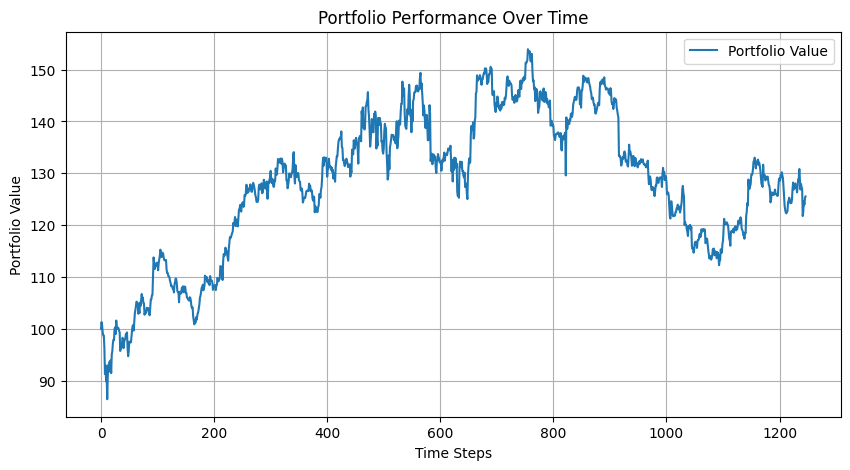

In [15]:
import matplotlib.pyplot as plt

# Reset environment
obs, _ = env.reset()
done = False

# Store portfolio values
portfolio_values = [env.portfolio_value]

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    portfolio_values.append(env.portfolio_value)  # Store value at each step
    env.render()  # Print current status

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label="Portfolio Value")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Performance Over Time")
plt.legend()
plt.grid()
plt.show()
